In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

In [19]:
dir_path = "../process/"
#logs_df = pd.read_csv(f"{dir_path}external_test_data.csv", encoding='utf-8')
logs_df_1 = pd.read_csv(f"{dir_path}3_22external_test_data_heuristic_prediction.csv", encoding='utf-8')
logs_df_1=logs_df_1[["Content", "Clean_Content", "Level", "PrioridadEtiqueta"]]
print(logs_df_1.shape)
logs_df_1.head()

(320, 4)


,Content,Clean_Content,Level,PrioridadEtiqueta
0,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error
1,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error
2,mod_jk child workerEnv in error state 7,child workerenv error state,Error,Error
3,mod_jk child workerEnv in error state 7,child workerenv error state,Error,Error
4,jk2_init() Found child 6755 in scoreboard slot 6,child scoreboard slot,Informativo,Informativo


In [21]:
logs_df_2 = pd.read_csv(f"{dir_path}4_10external_test_data_tdidf_prediction.csv", encoding='utf-8')
print(logs_df_2.shape)
logs_df_2=logs_df_2[["Clean_Content", "Predicted_Level"]]

logs_df_2.head()

(320, 7)


,Clean_Content,Predicted_Level
0,animating brightness target rate,Informativo
1,getrunningappprocesses caller does hold limiti...,Advertencia
2,issimpinsecure msimdatas null,Informativo
3,child scoreboard slot,Informativo
4,workerenv init ok httpd conf properties,Informativo


In [22]:
logs_df_3= pd.read_csv(f"{dir_path}5_10external_test_data_word2vect_prediction.csv", encoding='utf-8')
print(logs_df_3.shape)
logs_df_3=logs_df_3[["Clean_Content", "Predicted_Level"]]

logs_df_3.head()

(320, 7)


,Clean_Content,Predicted_Level
0,animating brightness target rate,Informativo
1,getrunningappprocesses caller does hold limiti...,Advertencia
2,issimpinsecure msimdatas null,Error
3,child scoreboard slot,Informativo
4,workerenv init ok httpd conf properties,Informativo


In [20]:
#logs_df_1

In [24]:
# Merge all on 'Content'
merged = pd.merge(logs_df_1, logs_df_2, on='Clean_Content')
merged = pd.merge(merged, logs_df_3, on='Clean_Content')

In [28]:
merged.columns =["Content", "Clean_Content", "real", "heuristicas", "tfidf", "word2vec"]

merged.head()

,Content,Clean_Content,real,heuristicas,tfidf,word2vec
0,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error
1,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error
2,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error
3,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error
4,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error


###  Paso 1: Calcular si cada predicción fue correcta

In [54]:

for col in ['heuristicas', 'tfidf', 'word2vec']:
    merged[f'{col}_correcto'] = (merged['real'] == merged[col]).astype(int)

# Verificamos que los datos estén correctos
merged.head()


,Content,Clean_Content,real,heuristicas,tfidf,word2vec,heuristicas_correcto,tfidf_correcto,word2vec_correcto
0,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error,1,1,1
1,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error,1,1,1
2,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error,1,1,1
3,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error,1,1,1
4,mod_jk child workerEnv in error state 6,child workerenv error state,Error,Error,Error,Error,1,1,1


## Paso 2: Prueba de Friedman

In [64]:
# 2. Aplicar la prueba de Friedman
stat, p = friedmanchisquare(
    merged['heuristicas_correcto'],
    merged['tfidf_correcto'],
    merged['word2vec_correcto']
)
print(f"Estadístico de Friedman: {stat:.3f}, p-valor: {p:.4f}")

Estadístico de Friedman: 14174.154, p-valor: 0.0000


###  Paso 3: Prueba post-hoc

In [66]:
# 3. Reorganizar los datos en formato largo para la prueba post-hoc
long_data = pd.melt(
    merged[['heuristicas_correcto', 'tfidf_correcto', 'word2vec_correcto']],
    var_name='modelo', value_name='correcto'
)

# Asegurarse de que las columnas existen
print(long_data.head())  # Esto debe mostrar columnas: 'modelo' y 'correcto'

# 4. Aplicar prueba de Dunn con corrección de Holm
dunn = sp.posthoc_dunn(long_data, group_col='modelo', val_col='correcto', p_adjust='holm')
print("\nTest post-hoc de Dunn-Holm (p-valores):\n", dunn)


                 modelo  correcto
0  heuristicas_correcto         1
1  heuristicas_correcto         1
2  heuristicas_correcto         1
3  heuristicas_correcto         1
4  heuristicas_correcto         1

Test post-hoc de Dunn-Holm (p-valores):
                       heuristicas_correcto  tfidf_correcto  word2vec_correcto
heuristicas_correcto          1.000000e+00    1.683417e-15       1.683417e-15
tfidf_correcto                1.683417e-15    1.000000e+00       9.863778e-01
word2vec_correcto             1.683417e-15    9.863778e-01       1.000000e+00


In [69]:
# Paso 4: Calcular rangos promedio por fila
ranking_data = merged[['heuristicas_correcto', 'tfidf_correcto', 'word2vec_correcto']]
avg_ranks = ranking_data.rank(axis=1, method='average', ascending=False).mean()
avg_ranks = avg_ranks.sort_values()
avg_ranks

tfidf_correcto          1.996729
word2vec_correcto       1.996750
heuristicas_correcto    2.006521
dtype: float64

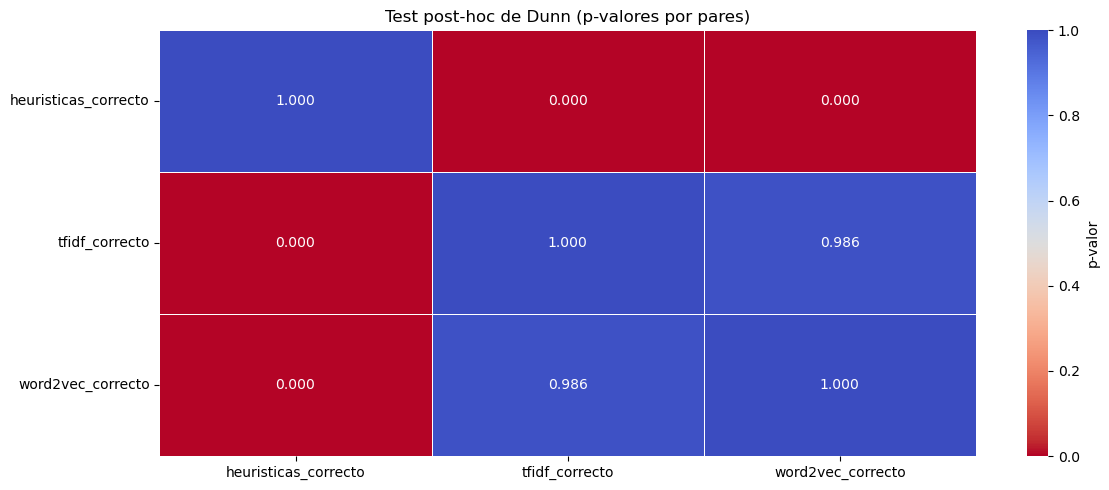

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un heatmap de los p-valores
plt.figure(figsize=(12, 5))
sns.heatmap(dunn, annot=True, fmt=".3f", cmap="coolwarm_r", cbar_kws={'label': 'p-valor'}, linewidths=0.5)

# Añadir detalles al gráfico
plt.title("Test post-hoc de Dunn (p-valores por pares)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


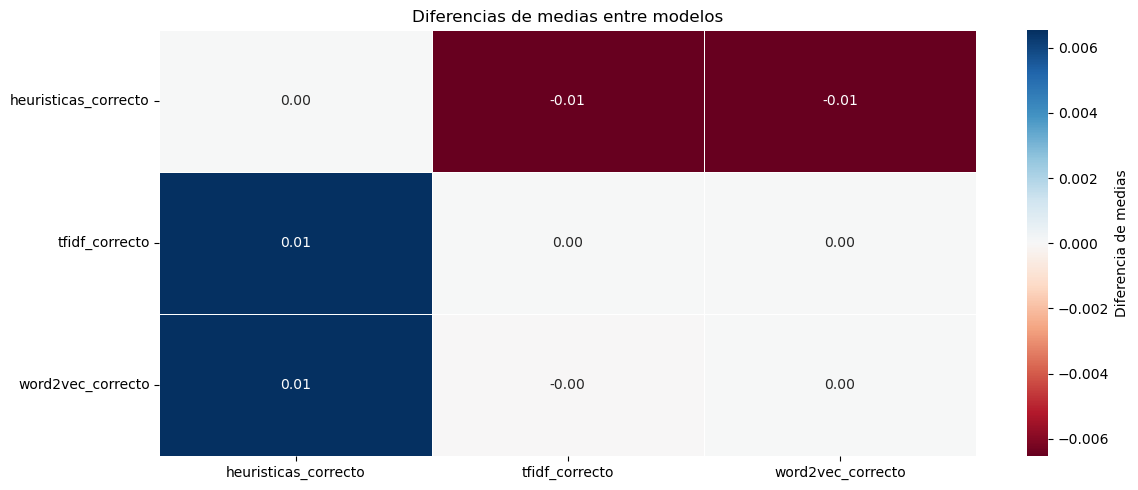

In [75]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Obtener solo las columnas correctas
scores = merged[['heuristicas_correcto', 'tfidf_correcto', 'word2vec_correcto']]

# Paso 2: Calcular la matriz de diferencias de medias
models = scores.columns
diff_means = pd.DataFrame(index=models, columns=models, dtype=float)

for i in models:
    for j in models:
        diff_means.loc[i, j] = scores[i].mean() - scores[j].mean()

# Paso 3: Graficar heatmap de diferencias de medias
plt.figure(figsize=(12, 5))
sns.heatmap(diff_means.astype(float), annot=True, fmt=".2f", cmap="RdBu", center=0,
            linewidths=0.5, cbar_kws={"label": "Diferencia de medias"})

plt.title("Diferencias de medias entre modelos")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


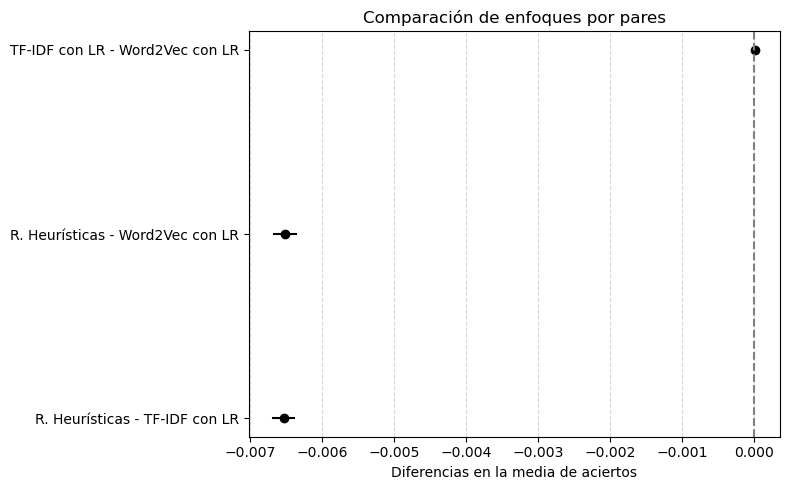

In [81]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos evaluados
models = ['heuristicas_correcto', 'tfidf_correcto', 'word2vec_correcto']
model_names = {
    'heuristicas_correcto': 'R. Heurísticas',
    'tfidf_correcto': 'TF-IDF con LR',
    'word2vec_correcto': 'Word2Vec con LR'
}

# Función bootstrap para intervalo de confianza de diferencia de medias
def bootstrap_diff_mean(a, b, n_bootstrap=1000, ci=95):
    diffs = []
    for _ in range(n_bootstrap):
        sample_a = np.random.choice(a, size=len(a), replace=True)
        sample_b = np.random.choice(b, size=len(b), replace=True)
        diffs.append(np.mean(sample_a) - np.mean(sample_b))
    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    return np.mean(diffs), lower, upper

# Comparaciones por pares
results = []
for m1, m2 in itertools.combinations(models, 2):
    mean_diff, ci_lower, ci_upper = bootstrap_diff_mean(merged[m1], merged[m2])
    results.append({
        'comparison': f"{model_names[m1]} - {model_names[m2]}",
        'mean_diff': mean_diff,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

# Crear DataFrame
results_df = pd.DataFrame(results)

# Gráfico tipo Tukey plot
plt.figure(figsize=(8, 5))
for i, row in results_df.iterrows():
    plt.plot([row['ci_lower'], row['ci_upper']], [i, i], color='black')
    plt.plot(row['mean_diff'], i, 'o', color='black')

plt.axvline(0, linestyle='--', color='gray')
plt.yticks(range(len(results_df)), results_df['comparison'])
plt.xlabel("Diferencias en la media de aciertos")
plt.title("Comparación de enfoques por pares")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
